# Learning Algorithm

We use [Deep Deterministic Policy Gradient (DDGP)](https://arxiv.org/abs/1509.02971) to solve this environment. It is an extension of DQN to continuous action space. The fundamental idea is to have two networks, an **actor** and a **critic**. The actor predicts which action to take, given a state $s$. The critic is basically the value function.

## Hyperparameters

We choose the following hyperparameters:

+ Both the actor and the critic are two-layer neural networks with 300 hidden units in each.
+ Relu activation functions are used in both
+ Adam optimizer is used with a learning rate of 1e-3 for the critic and 1e-4 for the actor.
+ The discount factor $\gamma$ is set to 0.99
+ The soft target update parater $\tau$ is set to 1e-3
+ L2 weight decay of the critic was set to 0.0001
+ Batch size was set to 64
+ The gradient was updated every second step
+ A normal distribution was used to add randomness to the Ornstein-Uhlenbeck process.

In the code cell below, we perform the training. The weights are saved as well.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import environment, agent, model
from collections import deque


def train(environment, agent, n_episodes=1000, max_t=1000,
          solve_score=30.0,
          graph_when_done=True):
    """ Run training loop for DQN.

    Params
    ======
        environment: environment object
        agent: agent object
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        solve_score (float): criteria for considering the environment solved
        graph_when_done (bool): whether to show matplotlib graphs of the training run
    """
    
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_episodes+1):
        rewards = []
        state = environment.reset()
        # loop over steps
        for t in range(max_t):
            # select an action
            action = agent.act(state)
            # take action in environment
            next_state, reward, done = environment.step(action)
            # update agent with returned information
            agent.step(state, action, reward, next_state, done)
            state = next_state
            rewards.append(reward)
            if any(done):
                break
        
        # every episode
        buffer_len = len(agent.memory)
        per_agent_rewards = []  # calculate per agent rewards
        for i in range(agent.n_agents):
            per_agent_reward = 0
            for step in rewards:
                per_agent_reward += step[i]
            per_agent_rewards.append(per_agent_reward)
        
        score = np.mean(per_agent_rewards)
        scores_deque.append(score)
        scores.append(score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")

        # if solved
        if i_episode > 100 and np.mean(scores_deque) >= 30:
            torch.save(agent.actor_local.state_dict(), 'checkpoints/solved.actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoints/solved.critic.pth')
            break

    return scores


model = model.CriticTwoTimes()
agent = agent.DDPG(model)

environment = environment.UnityMLVectorMultiAgent()

scores = train(environment=environment, agent=agent)

Actor(
  (fc1): Linear(in_features=33, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=4, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 300]          10,200
            Linear-2                  [-1, 300]          90,300
            Linear-3                    [-1, 4]           1,204
Total params: 101,704
Trainable params: 101,704
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.39
Estimated Total Size (MB): 0.39
----------------------------------------------------------------
Critic(
  (fcs1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=404, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_f

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 1	Average Score: 0.72	Score: 0.72

KeyboardInterrupt: 

We plot the rewards as function of the episode:

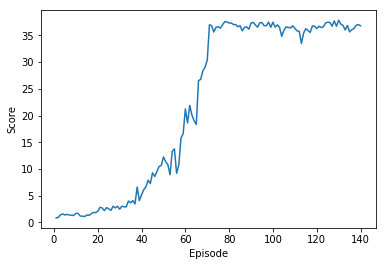

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

## Ideas for Improvement

Other enhancements that I did not have time to explore but may yield promising results:
+ There are other algorithms that could be used, like [PPO](https://arxiv.org/abs/1707.06347). 
+ As in the [navigation project](https://github.com/NOllAl/NavigationDeepRL) we could use prioritized experience replay. 
+ Use Bayesian optimization to find the best hyperparameters and speed up training further.